In [7]:
#生成少一个侧链的分子

import numpy as np
import pickle

from ddc_pub import ddc_v3 as ddc
import molvecgen
import rdkit, h5py

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, QED, rdFMCS
from rdkit import rdBase
import pandas as pd

class mol_generator:
    def __init__(self, seed_smile: str = "", sub_smile:str = "", model: str = "", qsar_model: str = ""):
        self.mols = []
        self.target = []
        self.target_names = ["logp", "tpsa", "sub_similarity", "qed", "hba", "hbd"]
        self.sani_mols = []
        self.sani_properties = []
        self.data = None
        self.set_seed(seed_smile)
        self.set_sub(sub_smile)
        self.set_model(model)
        self.set_qsar_model(qsar_model)

    def set_seed(self, seed_smile):
        if(seed_smile == ""):
            return
        #self.seed_smile = seed_smile
        self.seed_mol = Chem.MolFromSmiles(seed_smile)

        print("Seed Molecular:")
        print(Chem.MolToSmiles(self.seed_mol))

    def set_sub(self, sub_smile):
        if(sub_smile == ""):
            return
        self.sub_mol = Chem.MolFromSmiles(sub_smile)

        print("Substruct:")
        print(Chem.MolToSmiles(self.sub_mol))

    def set_model(self, model):
        if(model == ""):
            return
        self.model = ddc.DDC(model_name=model)

    def set_qsar_model(self, qsar_model):
        if(qsar_model == ""):
            return
        self.qsar_model = pickle.load(open(qsar_model, "rb"))["classifier_sv"]

    #Calculate the similarity between the aimed substructure and generated mol
    def get_sim(self, mol, sub_mol) -> float: 
        try:
            res = rdFMCS.FindMCS([mol, sub_mol], timeout=1, bondCompare=rdFMCS.BondCompare.CompareAny, ringMatchesRingOnly=True, atomCompare=rdFMCS.AtomCompare.CompareAny)
            if res.smartsString == "" or res.canceled:
                return 0
            mcs_mol = Chem.MolFromSmarts(res.smartsString)
            Chem.SanitizeMol(mcs_mol)

            mcs_mol_fp = AllChem.GetMorganFingerprintAsBitVect(mcs_mol, 2, nBits=2048)
            sub_mol_fp = AllChem.GetMorganFingerprintAsBitVect(sub_mol, 2, nBits=2048)
            sim = DataStructs.FingerprintSimilarity(sub_mol_fp, mcs_mol_fp)

            return sim
        except Exception as e:
            print("...Exception Occurred at {:1}:".format(Chem.MolToSmiles(mol)))
            print(e)
            return 0

    def get_descriptors(self, mol):
        logp = Descriptors.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        sim = self.get_sim(mol, self.sub_mol)
        hba = rdMolDescriptors.CalcNumHBA(mol)
        hbd = rdMolDescriptors.CalcNumHBD(mol)
        qed = QED.qed(mol)
        
        return [logp, tpsa, sim, qed, hba, hbd]

    def sanitize(self, mol):  # 检查分子
        try:
            Chem.SanitizeMol(mol)
            return mol
        except Exception as e:
            pass
            #print(e)

    # 采样指定性质的分子
    def sample(self, sample_times: int = 4, conditions: list = [None]*6):
        # 确定目标
        #assert len(conditions) >= 7
        self.target = self.get_descriptors(self.seed_mol)
        for i in range(len(conditions)):
            if(conditions[i] != None):
                self.target[i] = conditions[i]
        self.target = np.array(self.target)
        print("target:{:}".format(self.target))
        # 采样
        smiles_out = []
        self.model.batch_input_length = 256  # 太大会减慢速度
        for i in range(sample_times):
            smiles, _ = self.model.predict_batch(latent=self.target.reshape(1, -1), temp=1.0)
            smiles_out.append(smiles)
        smiles_out = np.concatenate(smiles_out)
        self.mols = [Chem.MolFromSmiles(smi) for smi in smiles_out]
        # 检查分子
        self.sani_mols.clear()
        self.sani_properties.clear()
        for mol in self.mols:
            if(mol != None):
                self.sani_mols.append(self.sanitize(mol))
        for mol in self.sani_mols:
            if(mol != None):
                self.sani_properties.append(self.get_descriptors(mol))
        # 打印结果
        print("生成分子数:{:},有效性:{:}".format(
            len(self.mols), len(self.sani_mols)/len(self.mols)))

    # 根据id显示生成的分子
    def showmol(self, i):  
        print(Chem.MolToSmiles(self.sani_mols[i]))

    #筛选sub_similarity==1的分子
    def filter_data(self, filename: str=""):
        #筛选结果
        self.binmols = [[i.ToBinary() for i in self.sani_mols]]
        self.data = np.concatenate([np.asarray(self.binmols).T, self.sani_properties])
        self.dataframe = pd.DataFrame(self.data, columns=["binmol"]+self.target_names, copy=True)
        self.filtered_data = self.dataframe.loc[[eval(i)==1 for i in self.dataframe["sub_similarity"]]]
        print(self.filtered_data.head(5))
        #保存文件
        with h5py.File(filename, "w") as f:
            f.create_dataset("mols", data=np.asarray(self.filtered_data["binmol"]))



In [2]:
rdBase.DisableLog("rdApp.*")

#创建生成器
generator_1 = mol_generator(sub_smile="C1C(C2(=O))C(=O)C=CC2CC1") 

#设置种子
#generator_1.set_seed("CN(C)CCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl") 
#generator_1.set_seed("CC1(C)C(CC[C@@]2(C)[C@@]1([H])CC[C@@]([C@@]34C)(C)[C@]2([H])C[C@@](C)(C4=O)C(C)=C(C(OC)=O)C3=O)=O")
generator_1.set_seed("CC1(C)C(CCC2(C)C1CCC(C34C)(C)C2CC(C)(C4=O)C(C)=C(C(OC)=O)C3=O)=O")
#generator_1.set_sub("O=C(OC)C1=CC(C2=O)CCCC2C1=O")

#设置生成模型
generator_1.set_model("models/model_0808") 

#设置QSAR模型
#generator_1.set_qsar_model("models/qsar_model.pickle") 

#采样/生成
generator_1.sample(4)


Substruct:
O=C1C=CC2CCCC1C2=O
Seed Molecular:
COC(=O)C1=C(C)C2(C)CC3C4(C)CCC(=O)C(C)(C)C4CCC3(C)C(C)(C1=O)C2=O
Initializing model in test mode.
Loading model.
'mol_to_latent_model' not found, setting to None.
Loading finished in 4 seconds.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Latent_Input (InputLayer)       [(None, 6)]          0                                            
__________________________________________________________________________________________________
Decoder_Inputs (InputLayer)     [(None, 142, 35)]    0                                            
__________________________________________________________________________________________________
latent_to_states_model (Model)  [(None, 512), (None, 33792       Latent_Input[0][0]               
____________________________________________________

In [ ]:
#筛选结果
binmols = [[i.ToBinary() for i in generator_1.sani_mols]]
np.shape(binmols.T)

In [11]:
np.shape(generator_1.sani_properties)

(880, 6)

In [9]:
new_array = np.resize(generator_1.sani_properties, (6,880))
np.size(new_array)

5280

In [ ]:
data = np.concatenate([np.asarray(binmols).T, generator_1.sani_properties], axis=0)
dataframe = pd.DataFrame(data, columns=["binmol"]+generator_1.target_names, copy=True)
filtered_data = dataframe.loc[[eval(i)==1 for i in dataframe["sub_similarity"]]]
print(filtered_data.head(5))
#保存文件
with h5py.File("datasets/GENERATED_MOLS_1.h5", "w") as f:
    f.create_dataset("mols", data=np.asarray(filtered_data["binmol"]))

In [2]:
dataset_filename = r"datasets/GENERATED_MOLS_1"
with h5py.File(dataset_filename, "r") as f:
    binmols = np.asarray(f["mols"])

In [18]:
import pickle

ncp_data = [pickle.load(open("ncp_{:}.pickle".format(i), "rb")) for i in range(7,8)]

In [22]:
import pandas as pd
import numpy as np
for i in range(1):
    nextCharProbs = np.asarray(ncp_data[i].copy(), dtype='float64')
    sum = np.sum(nextCharProbs[0])
    print(sum)
    nextCharProbs = np.multiply(nextCharProbs,[1/sum])

    '''nextCharProbs = []
    for j in ncp_data[i]:
        nextCharProb = []
        for k in j:
            nextCharProb.append(int(k * 1e+6) * 1e-6)
        nextCharProbs.append(nextCharProb)

    nextCharProbs = np.asarray(nextCharProbs, dtype='float64')'''

    #sums = [ncp[:-1].sum() for ncp in ncps]
    nextCharProb = nextCharProbs[0]
    display(nextCharProb)
    print("dtype = {:}".format(nextCharProb.dtype), "sum(pvals[:-1]) = {:}".format(nextCharProb[:-1].sum()))
    sampleidc = np.asarray(
                    [
                        np.random.multinomial(1, nextCharProb, 1).argmax() for nextCharProb in nextCharProbs
                    ])

0.9999995600000001


array([4.50910198e-04, 1.40000062e-07, 1.69200074e-05, 3.30000145e-07,
       8.50000374e-07, 9.32740410e-04, 9.70000427e-07, 1.30000057e-07,
       1.73709076e-03, 2.00000088e-08, 2.00000088e-08, 0.00000000e+00,
       2.08700092e-05, 4.00000176e-08, 1.70000075e-07, 9.64698854e-01,
       8.80700388e-04, 1.08550048e-04, 8.57631377e-03, 0.00000000e+00,
       1.90000084e-07, 6.30000277e-07, 1.97544087e-02, 5.00000220e-08,
       2.81776124e-03, 5.00000220e-08, 6.00000264e-08, 5.80000255e-07,
       1.00000044e-07, 2.00000088e-08, 5.00000220e-08, 3.80000167e-07,
       1.00000044e-08, 0.00000000e+00, 9.00000396e-08])

dtype = float64 sum(pvals[:-1]) = 0.9999999099999602


ValueError: sum(pvals[:-1]) > 1.0

In [24]:
import pickle 
with open("gnr_mol_1.pickle","rb") as f:
    sani_mols = pickle.load(f)
with open("gnr_mol_1_p.pickle","rb") as f:
    sani_properties = pickle.load(f)

print(len(sani_mols), len(sani_properties))

21344 21338


In [1]:
#查看生成的数据

import h5py
import numpy as np

#dataset_filename = r"C:\Users\Leave\OneDrive - hust.edu.cn\大创\pcko1-Deep-Drug-Coder-d6e7ef3\datasets\CHEMBL25_TRAIN_MOLS.h5"
dataset_filename = r"datasets/model_0813_1.h5"
with h5py.File(dataset_filename, "r") as f:
    binmols = np.asarray(f["mols"])
    #idxs = np.asarray(f["idxs"])
    #sims = np.asarray(f["sims"])

len(binmols)

2879

In [6]:
from rdkit import Chem, DataStructs
from rdkit.Chem import rdFMCS, RDKFingerprint

def get_sim(mol, sub_mol) -> float: 
    try:
        res = rdFMCS.FindMCS([mol, sub_mol], timeout=1, bondCompare=rdFMCS.BondCompare.CompareAny, ringMatchesRingOnly=True, atomCompare=rdFMCS.AtomCompare.CompareAny)
        if res.smartsString == "" or res.canceled:
            return 0
        mcs_mol = Chem.MolFromSmarts(res.smartsString)
        display(mcs_mol)
        Chem.SanitizeMol(mcs_mol)
        mcs_mol_fp = RDKFingerprint(mcs_mol)
        sub_mol_fp = RDKFingerprint(sub_mol)
        sim = DataStructs.FingerprintSimilarity(sub_mol_fp, mcs_mol_fp, metric=DataStructs.DiceSimilarity)
        return sim
    except Exception as e:
        #print(e)
        return 0




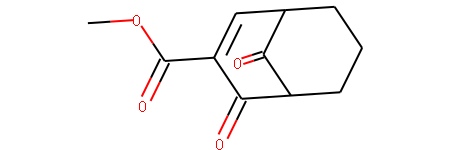

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
display(Chem.MolFromSmiles("O=C(OC)C1=CC(C2=O)CCCC2C1=O"))

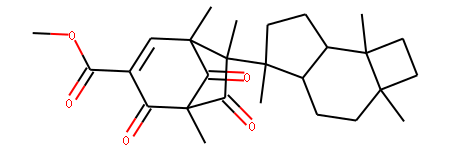

In [7]:
mol1 = Chem.MolFromSmiles("COC(=O)C1=CC2(C)C(=O)C(C)(C1=O)C(=O)C2(C)C1(C)CCC2C1CCC1(C)CCC21C")
sub_mol = Chem.MolFromSmiles("O=C(OC)C1=CC(C2=O)CCCC2C1=O")
display(mol1)

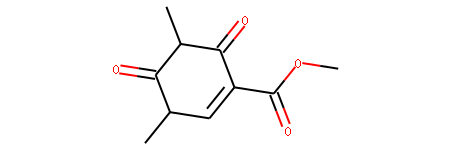

0.9681274900398407

In [8]:
get_sim(mol1,sub_mol)

In [43]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, QED, rdFMCS, RDKFingerprint
import numpy as np

def get_sim(mol, sub_mol) -> float: 
    #try:
        res = rdFMCS.FindMCS([mol, sub_mol], timeout=1, bondCompare=rdFMCS.BondCompare.CompareAny, ringMatchesRingOnly=True, atomCompare=rdFMCS.AtomCompare.CompareAny)
        if res.smartsString == "" or res.canceled:
            return 0
        mcs_mol = Chem.MolFromSmarts(res.smartsString)
        Chem.SanitizeMol(mcs_mol)

        mcs_mol_fp = RDKFingerprint(mcs_mol)
        #mcs_mol_fp = AllChem.GetMorganFingerprintAsBitVect(mcs_mol, 2, nBits=2048)
        sub_mol_fp = RDKFingerprint(sub_mol)
        #sub_mol_fp = AllChem.GetMorganFingerprintAsBitVect(sub_mol, 2, nBits=2048)
        print(len(mcs_mol_fp), len(sub_mol_fp))

        sim = DataStructs.FingerprintSimilarity(sub_mol_fp, mcs_mol_fp)

        return sim
    #except Exception as e:
        print("...Exception Occurred at {:1}:".format(Chem.MolToSmiles(mol)))
        print(e)
        return 0

get_sim(Chem.Mol(binmols[0]), Chem.Mol(binmols[1]))

2048 2048


0.45770065075921906

In [1]:
import sascorer

ModuleNotFoundError: No module named 'sascorer'